In [1]:
import os
import json
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

class OCTDataset(Dataset):
    def __init__(self, root_dir, indices=None, train=True, is_gentuity=False, transform=None):
        
        self.root_dir = Path(root_dir)
        self.train = train
        self.is_gentuity = is_gentuity
        self.transform = transform
        
        if self.is_gentuity:
            # Gentuity dataset has separate train and test folders
            split_dir = "train" if self.train else "test"
            self.images_dir = self.root_dir / split_dir / "images"
            self.masks_dir = self.root_dir / split_dir / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        else:
            # Terumo dataset has only train data
            self.images_dir = self.root_dir / "train" / "images"
            self.masks_dir = self.root_dir / "train" / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        
        # Filter image paths using indices if provided
        if indices is not None:
            self.samples = [self.samples[i] for i in indices]
        
        else:
            self.samples = sorted(self.images_dir.glob("*.tiff"))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")  # Keep it as a PIL Image
        
        # Load the corresponding mask
        mask_path = self.masks_dir / f"{image_path.stem}.json"
        with open(mask_path, "r") as f:
            mask_data = json.load(f)
        
        # Create a binary mask (0 and 1 values)
        mask = np.zeros(image.size[::-1], dtype=np.uint8)  # image.size gives (width, height)
        for coord in mask_data["mask"]:
            x, y = coord
            if 0 <= x < mask.shape[0] and 0 <= y < mask.shape[1]:
                mask[x, y] = 1
        
        mask = Image.fromarray(mask)
        
        # Apply the transformation if available
        if self.transform:
            # Convert image and mask to Tensor
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Add channel dimension for mask
        mask = mask.unsqueeze(0) if len(mask.shape) == 2 else mask  # Add channel if needed

        unique_id = mask_data["unique_id"]
        
        return image, mask, image_path.stem, unique_id  # Returning image filename too

In [ ]:
import pandas as pd

# Define the transformation using Compose
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),   # Resize images to a specific size using nearest interpolation
    transforms.ToTensor(),            # Convert image to Tensor (0 to 1 range)
])

# Sanity check for the gentuity data (with train and test folders)
gentuity_data_root = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"
train_dataset_gentuity = OCTDataset(gentuity_data_root, train=True, is_gentuity=True, transform=transform)
test_dataset_gentuity = OCTDataset(gentuity_data_root, train=False, is_gentuity=True, transform=transform)

train_loader_gentuity = DataLoader(train_dataset_gentuity, batch_size=4, shuffle=True)
test_loader_gentuity = DataLoader(test_dataset_gentuity, batch_size=4, shuffle=True)

# Sanity check for the terumo data (with only train folder)
terumo_data_root = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo"
train_dataset_terumo = OCTDataset(terumo_data_root, train=True, is_gentuity=False, transform=transform)

train_loader_terumo = DataLoader(train_dataset_terumo, batch_size=4, shuffle=True)

Sanity check for gentuity train dataset:
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 0


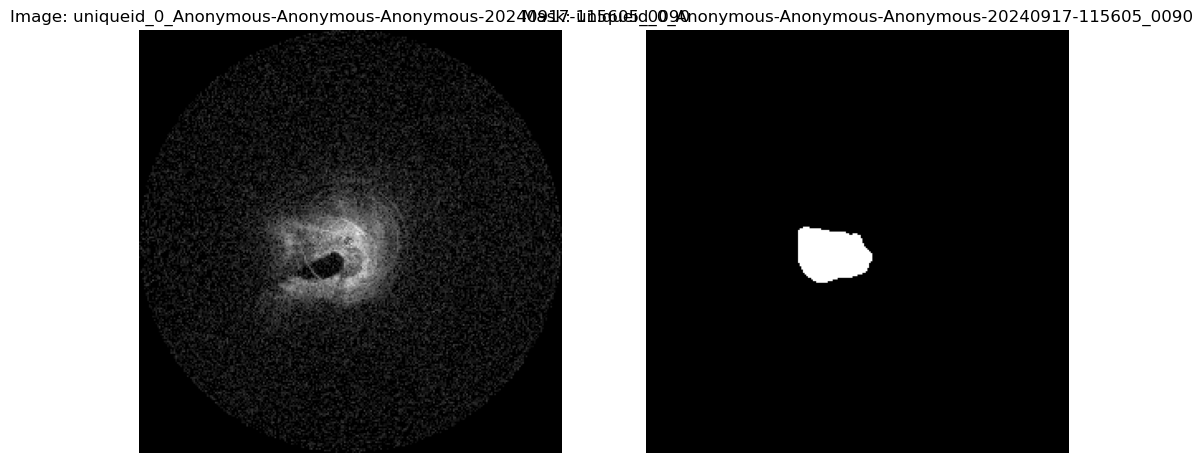


Sanity check for gentuity test dataset:
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 2


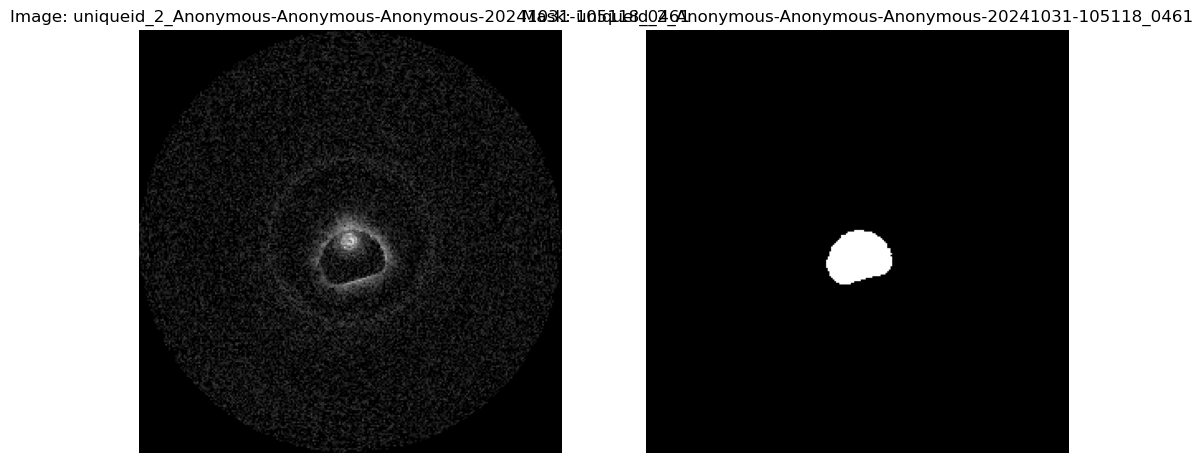


Sanity check for terumo dataset:
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 7


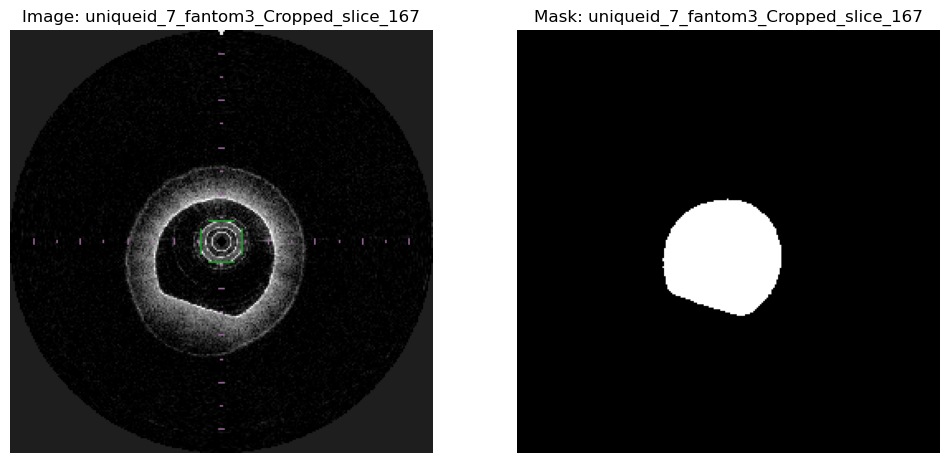

In [3]:
# Function for sanity check with plotting
def sanity_check(dataloader):
    for images, masks, filenames, unique_id in dataloader:
        print(f"Image batch shape: {images.shape}")
        print(f"Mask batch shape: {masks.shape}")
        # Just display a single sample from the batch
        print(f"Single image shape: {images[0].shape}")
        print(f"Single mask shape: {masks[0].shape}")
        print(f"Unique ID: {unique_id[0]}")
        
        # Plotting the image and the mask
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        ax[0].imshow(images[0].permute(1, 2, 0).numpy())  # Convert from CHW to HWC for plotting
        ax[0].set_title(f"Image: {filenames[0]}")
        ax[0].axis('off')
        
        ax[1].imshow(masks[0].squeeze().numpy(), cmap='gray')  # Squeeze to remove channel dimension
        ax[1].set_title(f"Mask: {filenames[0]}")
        ax[1].axis('off')
        
        plt.show()
        break  # Display just the first batch for the sanity check

# Run sanity checks
print("Sanity check for gentuity train dataset:")
sanity_check(train_loader_gentuity)

print("\nSanity check for gentuity test dataset:")
sanity_check(test_loader_gentuity)

print("\nSanity check for terumo dataset:")
sanity_check(train_loader_terumo)

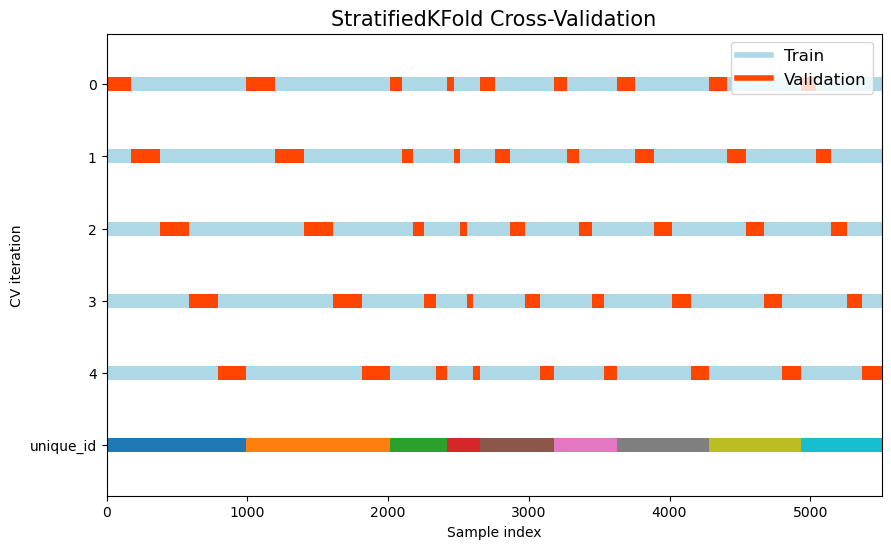

Sanity check for the first split:
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 0


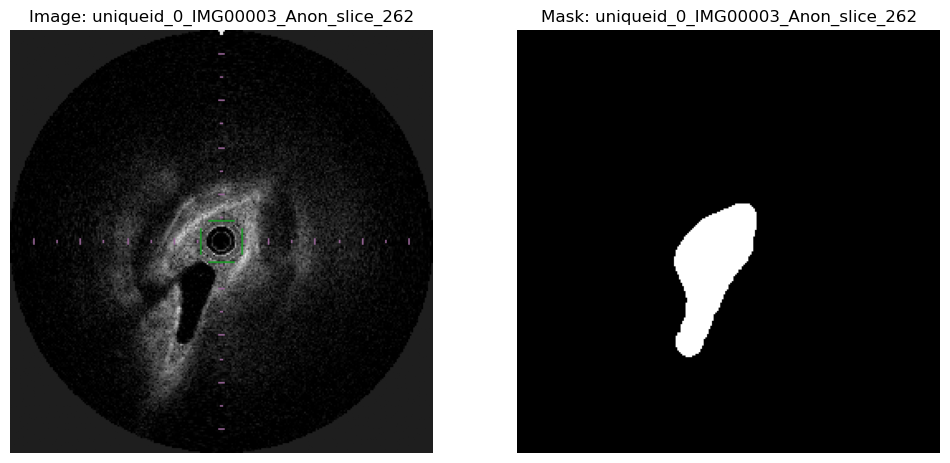

Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Single image shape: torch.Size([3, 256, 256])
Single mask shape: torch.Size([1, 256, 256])
Unique ID: 0


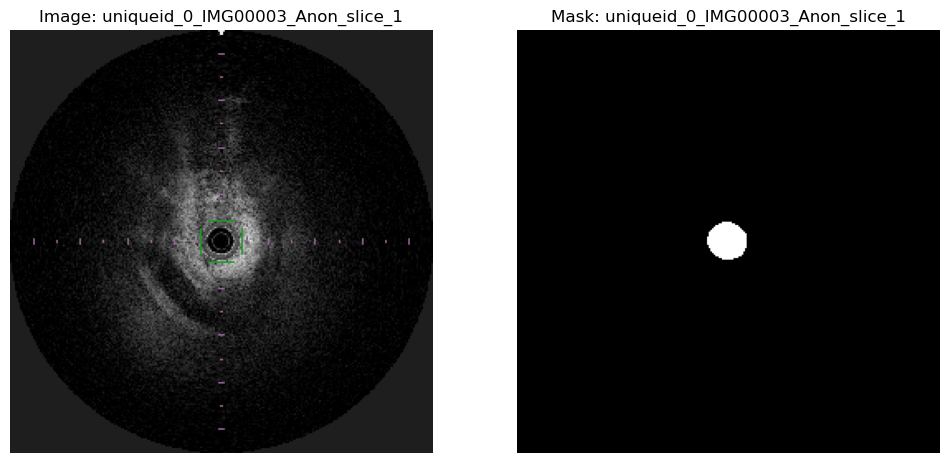

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define the root directory
root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo"

# Define the transformation using Compose
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),   # Resize images to a specific size using nearest interpolation
    transforms.ToTensor(),            # Convert image to Tensor (0 to 1 range)
])

# Load metadata for use in dataset creation
metadata_df = pd.read_csv(r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo\metadata.csv")

# Define the StratifiedKFold split
skf = StratifiedKFold(n_splits=5)
splits = list(skf.split(metadata_df, metadata_df["unique_id"]))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, cmap_data="tab10"):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # Mark the test samples
        indices[tr] = 0  # Mark the train samples

        # Visualize the results for the current split
        # Train samples in light blue, validation samples in redder orange
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=np.where(indices == 0, '#add8e6', '#ff4500'),  # Set light blue and redder orange
            marker="_",
            lw=lw,
        )

    # Plot the unique_id at the end (instead of class labels)
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Add a legend for train and validation splits
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#add8e6', lw=4, label='Train'),
        Line2D([0], [0], color='#ff4500', lw=4, label='Validation'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Formatting
    yticklabels = list(range(n_splits)) + ["unique_id"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title(f"{type(cv).__name__} Cross-Validation", fontsize=15)
    return ax

# Visualize splits
def visualize_cv_splits(metadata_df, n_splits=9):
    # Extract unique IDs and their corresponding target (unique_id)
    unique_ids = metadata_df["unique_id"].values

    # Initialize StratifiedKFold with n_splits
    skf = StratifiedKFold(n_splits=n_splits)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the cross-validation splits
    plot_cv_indices(
        skf, X=metadata_df, y=unique_ids, ax=ax, n_splits=n_splits
    )

    plt.show()

# Call the function to visualize the splits
visualize_cv_splits(metadata_df, n_splits=5)

# Example: Load the first split
train_indices, val_indices = splits[0]
train_dataset = OCTDataset(root_dir, indices=train_indices, transform=transform)
val_dataset = OCTDataset(root_dir, indices=val_indices, transform=transform)

# Use DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Sanity check for the first split
print("Sanity check for the first split:")
sanity_check(train_loader)
sanity_check(val_loader)

In [2]:
# Iterate through all splits and perform sanity check
fig, axs = plt.subplots(len(splits), 4, figsize=(16, 4 * len(splits)))

for i, (train_indices, val_indices) in enumerate(splits):  
    # Create datasets for the current split
    train_dataset = OCTDataset(root_dir, indices=train_indices, transform=transform)
    val_dataset = OCTDataset(root_dir, indices=val_indices, transform=transform)
    
    # Create dataloaders for the current split
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
    
    # Perform sanity check for training data
    for images, masks, filenames, unique_id in train_loader:
        axs[i, 0].imshow(images[0].permute(1, 2, 0).numpy())
        axs[i, 0].set_title(f"Split {i+1} Train Image: {filenames[0]}")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(masks[0].squeeze().numpy(), cmap='gray')
        axs[i, 1].set_title(f"Split {i+1} Train Mask: {filenames[0]}")
        axs[i, 1].axis('off')
        break  # Display just the first batch for the sanity check
    
    # Perform sanity check for validation data
    for images, masks, filenames, unique_id in val_loader:
        axs[i, 2].imshow(images[0].permute(1, 2, 0).numpy())
        axs[i, 2].set_title(f"Split {i+1} Val Image: {filenames[0]}")
        axs[i, 2].axis('off')
        
        axs[i, 3].imshow(masks[0].squeeze().numpy(), cmap='gray')
        axs[i, 3].set_title(f"Split {i+1} Val Mask: {filenames[0]}")
        axs[i, 3].axis('off')
        break  # Display just the first batch for the sanity check

plt.tight_layout()
plt.show()

NameError: name 'splits' is not defined

In [2]:
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute the attention weights
        attention = self.sigmoid(self.conv2(self.sigmoid(self.conv1(x))))
        return x * attention  # Element-wise multiplication

# Define a large U-Net model with Attn
class Net(nn.Module):
    def __init__(self, input_channels=3, output_channels=1, initial_filters=64):
        super(Net, self).__init__()

        self.encoder1 = self.conv_block(input_channels, initial_filters)
        self.encoder2 = self.conv_block(initial_filters, initial_filters * 2)
        self.encoder3 = self.conv_block(initial_filters * 2, initial_filters * 4)
        self.encoder4 = self.conv_block(initial_filters * 4, initial_filters * 8)
        self.encoder5 = self.conv_block(initial_filters * 8, initial_filters * 16)

        self.pool = nn.MaxPool2d(2)

        # Adjusting channels to match attention input
        self.upconv5 = nn.ConvTranspose2d(initial_filters * 16, initial_filters * 8, kernel_size=2, stride=2)
        self.attn5 = AttentionBlock(initial_filters * 16)  # Updated input channels
        self.decoder5 = self.conv_block(initial_filters * 16, initial_filters * 8)

        self.upconv4 = nn.ConvTranspose2d(initial_filters * 8, initial_filters * 4, kernel_size=2, stride=2)
        self.attn4 = AttentionBlock(initial_filters * 8)  # Updated input channels
        self.decoder4 = self.conv_block(initial_filters * 8, initial_filters * 4)

        self.upconv3 = nn.ConvTranspose2d(initial_filters * 4, initial_filters * 2, kernel_size=2, stride=2)
        self.attn3 = AttentionBlock(initial_filters * 4)  # Updated input channels
        self.decoder3 = self.conv_block(initial_filters * 4, initial_filters * 2)

        self.upconv2 = nn.ConvTranspose2d(initial_filters * 2, initial_filters, kernel_size=2, stride=2)
        self.attn2 = AttentionBlock(initial_filters * 2)  # Updated input channels
        self.decoder2 = self.conv_block(initial_filters * 2, initial_filters)

        self.final_conv = nn.Conv2d(initial_filters, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        e5 = self.encoder5(self.pool(e4))

        # Decoding path with skip connections and attention
        d5 = torch.cat((self.upconv5(e5), e4), dim=1)
        d5 = self.attn5(d5)  # Apply attention
        d5 = self.decoder5(d5)

        d4 = torch.cat((self.upconv4(d5), e3), dim=1)
        d4 = self.attn4(d4)  # Apply attention
        d4 = self.decoder4(d4)

        d3 = torch.cat((self.upconv3(d4), e2), dim=1)
        d3 = self.attn3(d3)  # Apply attention
        d3 = self.decoder3(d3)

        d2 = torch.cat((self.upconv2(d3), e1), dim=1)
        d2 = self.attn2(d2)  # Apply attention
        d2 = self.decoder2(d2)

        # Final output layer
        out = self.final_conv(d2)

        return torch.sigmoid(out)  # Assuming binary segmentation

In [3]:
from ray import tune
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def dice_loss(pred, target, smooth=1.0):
    intersection = torch.sum(pred * target)
    return 1 - (2. * intersection + smooth) / (torch.sum(pred) + torch.sum(target) + smooth)

c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-22 15:54:44,541	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-22 15:54:45,651	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [29]:
from tqdm import tqdm

root_dir = r"C:\Users\johan\OneDrive - Aarhus universitet\9. Semester\Deep Learning\data_terumo_smoke_test"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare datasets for the fold
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# Initialize model with the hyperparameters from the config
net = Net().to(device)

# Define loss and optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Split the dataset into training and validation sets
dataset = OCTDataset(root_dir, transform=transform)
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=2, shuffle=False)
valloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

epochs = 2

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_pixels = 0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for images, masks, _, _ in progress_bar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=loss.item())

        # Calculate training accuracy (pixel-wise accuracy)
        pred = (outputs > 0.5).float()  # Assuming binary classification (adjust for multi-class)
        correct_train_predictions += torch.sum(pred == masks).item()
        total_train_pixels += masks.numel()

        progress_bar.set_postfix(loss=loss.item())

    # Calculate training loss and accuracy for the epoch
    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = correct_train_predictions / total_train_pixels
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    net.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_pixels = 0
    with torch.no_grad():  # No need to calculate gradients during validation
        for images, masks, _, _ in tqdm(valloader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = net(images)
            loss = dice_loss(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Calculate validation accuracy (pixel-wise accuracy)
            pred = (outputs > 0.5).float()  # Assuming binary classification (adjust for multi-class)
            correct_val_predictions += torch.sum(pred == masks).item()
            total_val_pixels += masks.numel()

    # Calculate validation loss and accuracy
    val_loss = val_loss / len(valloader.dataset)
    val_accuracy = correct_val_predictions / total_val_pixels
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/2], Training Loss: 0.9982, Training Accuracy: 0.7823


Epoch [1/2], Validation Loss: 0.9977, Validation Accuracy: 0.8665


Epoch [2/2], Training Loss: 0.9975, Training Accuracy: 0.8894


Epoch [2/2], Validation Loss: 0.9974, Validation Accuracy: 0.8941


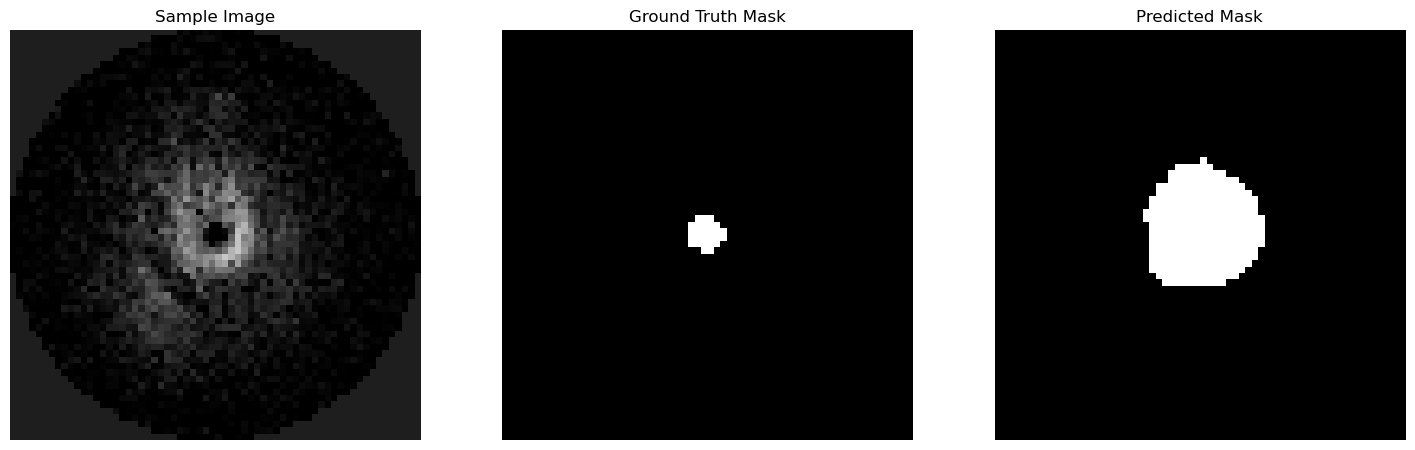

In [30]:
# Set the model to evaluation mode
net.eval()

# Load a sample image from the dataset
sample_image, sample_mask, _, _ = dataset[0]  # Change the index to load a different sample

# Move the sample image to the appropriate device
sample_image = sample_image.to(device).unsqueeze(0)  # Add batch dimension

# Make a prediction
with torch.no_grad():
    prediction = net(sample_image)

# Convert the prediction to a binary mask
predicted_mask = (prediction > 0.5).float()

# Plot the sample image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Sample Image")
ax[0].axis('off')

ax[1].imshow(sample_mask.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()

In [ ]:
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray import tune, air
from ray.air import session
from ray.tune.search.optuna import OptunaSearch

def train_model(config):
    net = Net().to(device)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    # Load existing checkpoint through `get_checkpoint()` API.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            net.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    if config["smoke_test"]:
        # Split the dataset into training and validation sets
        root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo_smoke_test"
        dataset = OCTDataset(root_dir, transform=transform)
        val_size = int(0.1 * len(dataset))
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        trainloader = DataLoader(train_dataset, batch_size=2, shuffle=False)
        valloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

    else:
        print("Training on full dataset")

    epochs = config["epochs"]
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct_train_predictions = 0
        total_train_pixels = 0

        progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for images, masks, _, _ in progress_bar:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

            # Calculate training accuracy (pixel-wise accuracy)
            pred = (outputs > 0.5).float()  # Assuming binary classification (adjust for multi-class)
            correct_train_predictions += torch.sum(pred == masks).item()
            total_train_pixels += masks.numel()

            progress_bar.set_postfix(loss=loss.item())

        # Calculate training loss and accuracy for the epoch
        train_loss = running_loss / len(trainloader.dataset)
        train_accuracy = correct_train_predictions / total_train_pixels
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation phase
        net.eval()
        val_loss = 0.0
        correct_val_predictions = 0
        total_val_pixels = 0
        with torch.no_grad():  # No need to calculate gradients during validation
            for images, masks, _, _ in tqdm(valloader, desc="Validation", leave=False):
                images, masks = images.to(device), masks.to(device)

                outputs = net(images)
                loss = dice_loss(outputs, masks)
                val_loss += loss.item() * images.size(0)

                # Calculate validation accuracy (pixel-wise accuracy)
                pred = (outputs > 0.5).float()  # Assuming binary classification (adjust for multi-class)
                correct_val_predictions += torch.sum(pred == masks).item()
                total_val_pixels += masks.numel()

        # Calculate validation loss and accuracy
        val_loss = val_loss / len(valloader.dataset)
        val_accuracy = correct_val_predictions / total_val_pixels
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        session.report({"val_loss": val_loss, "val_accuracy": val_accuracy})
    
    print("Finished Training")

def test_best_model(best_result):
    best_trained_model = Net()
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"
    dataset = OCTDataset(root_dir, transform=transform, is_gentuity=True, train=False)
    testloader = DataLoader(dataset, batch_size=4, shuffle=False)

    net.to(device)
    correct, loss = 0, 0.0

    with torch.no_grad():  # Disable gradient calculation
        for images, masks, _, _ in tqdm(testloader, desc="Testing", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = net(images)
            loss = dice_loss(outputs, masks)
            loss += loss.item() * images.size(0)

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct += (predicted == masks).sum().item()

    # Calculate average loss and accuracy
    loss /= len(testloader.dataset)
    accuracy = correct / (len(testloader.dataset) * masks.size(1) * masks.size(2) * masks.size(3))

    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [5]:
search_space = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
    "epochs": tune.choice([2, 5, 10]),
    "smoke_test": True,
}

trainable_with_ressources = tune.with_resources(
    tune.with_parameters(train_model), 
    resources={"cpu": 1, "gpu": 1}
)

algo = OptunaSearch()

tuner = tune.Tuner(
    trainable_with_ressources,
    tune_config=tune.TuneConfig(
        metric="val_loss",
        mode="min",
        search_alg=algo,
        num_samples=1,
    ),

    run_config=air.RunConfig(
        stop={"training_iteration": 1},
    ),

    param_space=search_space,
)

ray.init(num_cpus=1, num_gpus=1, log_to_driver=False, ignore_reinit_error=True)

result_grid = tuner.fit()

print("Best config is:", result_grid.get_best_result().config,' with loss: ', result_grid.get_best_result().metrics['val_loss'])

2024-11-22 15:55:13,877	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_b0be0101
Traceback (most recent call last):
  File "c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\_private\worker.py", line 2656, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\johan\anaconda3\e

KeyError: 'val_loss'

In [10]:
m = result_grid.get_best_result().metrics